We use MCMC algorithm to research the Hubble Tension by the python packages __cobaya__ & __getdist__. Let's install them first.

In [ ]:
# !pip install cobaya --quiet

# !pip install getdist --quiet

     |████████████████████████████████| 332 kB 6.9 MB/s 
     |████████████████████████████████| 777 kB 41.0 MB/s 


Connecting the drive account to save the result.

In [ ]:
# # mount drive, only need to be done once
# from google.colab import drive
# drive.mount('/content/gdrive')

# %cd /content/gdrive/MyDrive/colab/COBAYA/

Mounted at /content/gdrive


Import some python packages to use the functions in the code.

In [ ]:
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
from scipy.constants import c
from scipy.integrate import quad

# for the analytic LambdaCDM growth rate
from scipy.special import hyp2f1

# for the WiggleZ covariance in the growth data
from scipy.linalg import block_diag

### Data sets

We load the hubble expansion data from Cosmic Chronometers and Baryon Acoustic Oscillations respectively, then plot their result. 

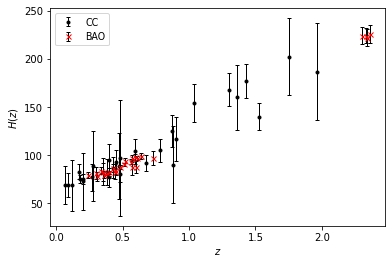

In [ ]:
# load CC and BAO expansion rate data
cc_loc = 'https://raw.githubusercontent.com/reggiebernardo/\
datasets/main/Hdz_2020_CConly.txt'
cc_data = np.loadtxt(cc_loc)

z_cc = cc_data[:, 0]
Hz_cc = cc_data[:, 1]
sigHz_cc = cc_data[:, 2]

bao_loc = 'https://raw.githubusercontent.com/reggiebernardo/\
datasets/main/Hdz_2020_BAOonly.txt'
bao_data = np.loadtxt(bao_loc)

z_bao = bao_data[:, 0]
Hz_bao = bao_data[:, 1]
sigHz_bao = bao_data[:, 2]

fig, ax = plt.subplots()
ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc, fmt = 'ko', ecolor = 'k', \
            markersize = 3, elinewidth = 1, capsize = 2, label = 'CC')
ax.errorbar(z_bao, Hz_bao, yerr = sigHz_bao, fmt = 'rx', ecolor = 'k', \
            markersize = 5, elinewidth = 1, capsize = 2, label = 'BAO')

ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$')
ax.legend(loc = 'upper left', prop = {'size': 9.5})
plt.show()

Our data sets also considered observation of Type Ia Supernovae in _Pentheon+ Analysis_

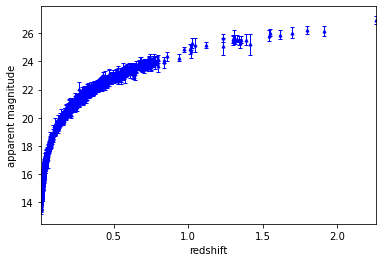

In [ ]:
loc_lcparam = 'https://github.com/PantheonPlusSH0ES/DataRelease/raw/main/\
Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat'

# pantheon plus systematics

lcparam = np.loadtxt(loc_lcparam, skiprows = 1, usecols = (2, 8, 9, 10, 11))

# setup pantheon samples
z_pp = lcparam[:, 0][111:]
mz_pp = lcparam[:, 1][111:]
sigmz_pp = lcparam[:, 2][111:]

#mMz_pp = lcparam[:, 3][111:]
sigmMz_pp = lcparam[:, 4][111:]

# apparent magnitudes
plt.errorbar(z_pp, mz_pp, yerr = sigmz_pp, \
             fmt = 'b^', markersize = 3, \
             ecolor = 'blue', elinewidth = 1, capsize = 2)
plt.xlim(min(z_pp), max(z_pp))
plt.xlabel('redshift')
plt.ylabel('apparent magnitude')
plt.show()

Also, we have to include the data of covariance matrix.

In [ ]:
# load the pantheon+ covariance matrix

loc_lcparam_sys = 'https://raw.githubusercontent.com/PantheonPlusSH0ES/\
DataRelease/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES_STAT%2BSYS.cov'
lcparam_sys = np.loadtxt(loc_lcparam_sys, skiprows = 1)

# pantheon plus systematics
cov = lcparam_sys.reshape(1701, 1701)
cov_inv = np.linalg.inv(cov[111:, 111:])

Finally, the redshift space distorsion measurements also should be loaded in.

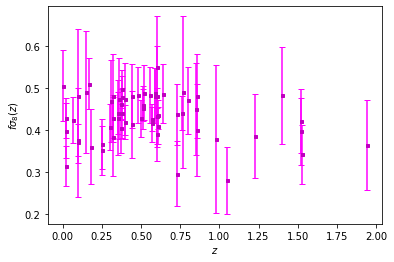

In [ ]:

# load growth RSD data
# loc_rsd = 'https://datasets/Growth_tableII.txt'
loc_rsd = 'https://raw.githubusercontent.com/reggiebernardo/datasets/\
main/Growth_tableII.txt'
rsd = np.loadtxt(loc_rsd, usecols = (0, 1, 2))

# the WiggleZ points (3x3) covariance
# wgz_loc = 'https://datasets/Cij_WiggleZ.txt'
wgz_loc = 'https://raw.githubusercontent.com/reggiebernardo/datasets/\
main/Cij_WiggleZ.txt'
C_wgz = np.loadtxt(wgz_loc)

# setup
z_rsd = rsd[:, 0]
fs8_rsd = rsd[:, 1]
sigfs8_rsd = rsd[:, 2]

fig, ax = plt.subplots()
ax.errorbar(z_rsd, fs8_rsd, yerr = sigfs8_rsd, fmt = 'ms', \
            ecolor = 'magenta', markersize = 3, elinewidth = 1.5, capsize = 3)
ax.set_xlabel('$z$')
ax.set_ylabel('$f \sigma_8(z)$')
plt.show()

# f*sigma_8 data covariance with WiggleZ
C_rsd_1 = np.diag(sigfs8_rsd[: 9]**2)
C_rsd_w = C_wgz
C_rsd_N = np.diag(sigfs8_rsd[12:]**2)

C_rsd = block_diag(C_rsd_1, C_rsd_w, C_rsd_N)
C_rsd_inv = np.linalg.inv(C_rsd)

### $\Lambda$CDM cosmology

We use $\Lambda$CDM as the model. And in order to build the function according to the data sets.<br> There are __Expansion Rate__ $H(z)$, __Apparant Magnitudes__ $m(z)$ and __Growth Rate__ $f\sigma_8(z)$.<br> Then we calculate the __Likelihood__ for each data based on these functions. 

In [ ]:
# expansion rate

def E(z, Om):
    Or = 0
    Ol = 1-Or-Om
    return np.sqrt(Om*(1+z)**3+Or*(1+z)**4+Ol)

# supernovae brightness

def E_inv(z, Om):
    return 1/E(z, Om)
  
def dL(z, Om, H0):
    rz = quad(E_inv, 0, z, args=(Om,))[0]
    return (1+z)*c/(H0)*rz

# SNe distance modulus

def mu(z, Om, H0):     
    return 5*np.log10(dL(z,Om,H0)*100)

# growth rate

def dltz(z, Om):
    '''analytic LambdaCDM density contrast \delta(z)'''
    a = 1/(1 + z)
    return a*hyp2f1(1/3, 1, 11/6, (a**3)*(1 - (1/Om)))

def dltpz(z, Om):
    '''analytic LambdaCDM \delta'(z)'''
    a = 1/(1 + z)
    dadz = -1/((1 + z)**2)
    term_1 = -2*hyp2f1(1/3, 1, 11/6, (a**3)*(1 - (1/Om)))
    term_2 = 3*hyp2f1(1/3, 2, 11/6, (a**3)*(1 - (1/Om)))
    return (term_1 + term_2)*dadz

def fs8(z, Om, s80):
    dlt0 = dltz(0, Om)
    return -(1 + z)*s80*dltpz(z, Om)/dlt0

# chi-squared measures

def like_CC(Om, H0):
    return sum(((Hz_cc-H0*E(z_cc, Om))**2)/sigHz_cc**2)

def like_BAO(Om, H0):
    return sum(((Hz_bao-H0*E(z_bao, Om))**2)/sigHz_bao**2)

#cov_inv = np.linalg.inv(cov_tot)

def like_SN(Om, H0, M):
    m_th = np.array([mu(z, Om, H0)+M for z in z_pp])
    m = mz_pp
    dm = m - m_th  
    return dm.T@cov_inv@dm

def like_RSD(Om, s80):
    #chi-squared for f*sigma_8(z) observations
    fs8_sol = fs8(z_rsd, Om, s80)
    Delta_fs8 = fs8_sol - fs8_rsd
    chi2 = Delta_fs8.T @ C_rsd_inv @ Delta_fs8
    return chi2

# testing the model Om = 0.3, H0 = 72, M = -19.3, s80 = 0.8
ll_CC = like_CC(0.3, 72)
ll_BAO = like_BAO(0.3, 72)
ll_SN = like_SN(0.3, 72, -19.3)
ll_RSD = like_RSD(0.3, 0.8)
print("check:", ll_CC + ll_BAO + ll_SN + ll_RSD)

def loglikelihood (Om, H0, M, s80):

    X_2 = like_CC(Om, H0) + like_SN(Om, H0, M) + like_BAO(Om, H0) + like_RSD(Om, s80)  
    
    return -0.5*X_2

check: 1564.3720896363495


### $\Lambda$CDM + MCMC: cosmology parameters estimation according to two priors.

Let's import cobaya, using MCMC to fit the data.

In [ ]:
from cobaya.run import run  

Now we have to make dictionaries including all the information been needed to run the MCMC.<br>
There are __Likelihood Function__ we defined above, __priors__ setting for each parameters, and the __samplers__.<br>
The progress would showed after starting to run it.

The first one we use the Plank(P18) measurements as the priors.

In [ ]:
info1 = {"likelihood": {"loglikeSNIa": loglikelihood}, \
         "params": {"Om": {"prior": {"min": 0.2, "max": 0.4}, \
                           "ref": {"min": 0.3, "max": 0.31}, \
                           "proposal": 0.005, "latex": r"\Omega_{m0}"}, \
                    "H0": {"prior": {"dist": "norm", "loc": 67.4, "scale": 0.5}, \
                           "ref": 67.4, "proposal": 0.002, "latex": r"H_0"}, \
                    "M": {"prior": {"min": -19.5, "max": -19.0}, \
                          "ref": {"min": -19.3, "max": -19.2}, \
                          "proposal": 0.005, "latex": r'M'}, \
                    "s80": {"prior": {"dist": "norm", "loc": 0.1, "scale": 1.2}, \
                            "ref": 0.7, "proposal": 0.002, "latex": r'\sigma_{8}'}}, \
         "sampler": {"mcmc": {"Rminus1_stop": 0.01, "max_tries": 10000}}}
        
info1["ouput"] = "chains/LCDMP18"
updated1_info, sampler1 = run(info1, force=True)       

INFO:loglikesnia:Initialized external likelihood.


[loglikesnia] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {loglikeSNIa: 6.11}


[model] Setting measured speeds (per sec): {loglikeSNIa: 6.11}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Initial point: Om:0.3042672, H0:67.4, M:-19.26802, s80:0.7


[mcmc] Initial point: Om:0.3042672, H0:67.4, M:-19.26802, s80:0.7


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2022-11-22 15:47:26 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2022-11-22 15:47:26 : 1 steps taken, and 0 accepted.


INFO:mcmc:Learn + convergence test @ 160 samples accepted.


[mcmc] Learn + convergence test @ 160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.440


[mcmc]  - Acceptance rate: 0.440


INFO:mcmc: - Convergence of means: R-1 = 14.769622 after 128 accepted steps


[mcmc]  - Convergence of means: R-1 = 14.769622 after 128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 15:48:26 : 355 steps taken, and 160 accepted.


[mcmc] Progress @ 2022-11-22 15:48:26 : 355 steps taken, and 160 accepted.


INFO:mcmc:Progress @ 2022-11-22 15:49:26 : 712 steps taken, and 306 accepted.


[mcmc] Progress @ 2022-11-22 15:49:26 : 712 steps taken, and 306 accepted.


INFO:mcmc:Learn + convergence test @ 320 samples accepted.


[mcmc] Learn + convergence test @ 320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.428


[mcmc]  - Acceptance rate: 0.428


INFO:mcmc: - Convergence of means: R-1 = 6.333024 after 256 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.333024 after 256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 15:50:26 : 1064 steps taken, and 438 accepted.


[mcmc] Progress @ 2022-11-22 15:50:26 : 1064 steps taken, and 438 accepted.


INFO:mcmc:Learn + convergence test @ 480 samples accepted.


[mcmc] Learn + convergence test @ 480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.405


[mcmc]  - Acceptance rate: 0.405


INFO:mcmc: - Convergence of means: R-1 = 1.648300 after 384 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.648300 after 384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 15:51:26 : 1417 steps taken, and 573 accepted.


[mcmc] Progress @ 2022-11-22 15:51:26 : 1417 steps taken, and 573 accepted.


INFO:mcmc:Learn + convergence test @ 640 samples accepted.


[mcmc] Learn + convergence test @ 640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.395


[mcmc]  - Acceptance rate: 0.395


INFO:mcmc: - Convergence of means: R-1 = 2.298499 after 512 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.298499 after 512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 15:52:26 : 1756 steps taken, and 704 accepted.


[mcmc] Progress @ 2022-11-22 15:52:26 : 1756 steps taken, and 704 accepted.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.381


[mcmc]  - Acceptance rate: 0.381


INFO:mcmc: - Convergence of means: R-1 = 0.099101 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.099101 after 640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 15:53:26 : 2110 steps taken, and 824 accepted.


[mcmc] Progress @ 2022-11-22 15:53:26 : 2110 steps taken, and 824 accepted.


INFO:mcmc:Progress @ 2022-11-22 15:54:26 : 2474 steps taken, and 954 accepted.


[mcmc] Progress @ 2022-11-22 15:54:26 : 2474 steps taken, and 954 accepted.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.376


[mcmc]  - Acceptance rate: 0.376


INFO:mcmc: - Convergence of means: R-1 = 0.580337 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.580337 after 768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 15:55:26 : 2826 steps taken, and 1057 accepted.


[mcmc] Progress @ 2022-11-22 15:55:26 : 2826 steps taken, and 1057 accepted.


INFO:mcmc:Learn + convergence test @ 1120 samples accepted.


[mcmc] Learn + convergence test @ 1120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.357


[mcmc]  - Acceptance rate: 0.357


INFO:mcmc: - Convergence of means: R-1 = 0.142428 after 896 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.142428 after 896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 15:56:26 : 3179 steps taken, and 1172 accepted.


[mcmc] Progress @ 2022-11-22 15:56:26 : 3179 steps taken, and 1172 accepted.


INFO:mcmc:Learn + convergence test @ 1280 samples accepted.


[mcmc] Learn + convergence test @ 1280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.350


[mcmc]  - Acceptance rate: 0.350


INFO:mcmc: - Convergence of means: R-1 = 0.379590 after 1024 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.379590 after 1024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 15:57:26 : 3534 steps taken, and 1288 accepted.


[mcmc] Progress @ 2022-11-22 15:57:26 : 3534 steps taken, and 1288 accepted.


INFO:mcmc:Progress @ 2022-11-22 15:58:27 : 3877 steps taken, and 1392 accepted.


[mcmc] Progress @ 2022-11-22 15:58:27 : 3877 steps taken, and 1392 accepted.


INFO:mcmc:Learn + convergence test @ 1440 samples accepted.


[mcmc] Learn + convergence test @ 1440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.343


[mcmc]  - Acceptance rate: 0.343


INFO:mcmc: - Convergence of means: R-1 = 0.145135 after 1152 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.145135 after 1152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 15:59:27 : 4242 steps taken, and 1498 accepted.


[mcmc] Progress @ 2022-11-22 15:59:27 : 4242 steps taken, and 1498 accepted.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.336


[mcmc]  - Acceptance rate: 0.336


INFO:mcmc: - Convergence of means: R-1 = 0.169642 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.169642 after 1280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:00:27 : 4599 steps taken, and 1614 accepted.


[mcmc] Progress @ 2022-11-22 16:00:27 : 4599 steps taken, and 1614 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:01:27 : 4954 steps taken, and 1708 accepted.


[mcmc] Progress @ 2022-11-22 16:01:27 : 4954 steps taken, and 1708 accepted.


INFO:mcmc:Learn + convergence test @ 1760 samples accepted.


[mcmc] Learn + convergence test @ 1760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.330


[mcmc]  - Acceptance rate: 0.330


INFO:mcmc: - Convergence of means: R-1 = 0.333424 after 1408 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.333424 after 1408 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:02:27 : 5307 steps taken, and 1823 accepted.


[mcmc] Progress @ 2022-11-22 16:02:27 : 5307 steps taken, and 1823 accepted.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.327


[mcmc]  - Acceptance rate: 0.327


INFO:mcmc: - Convergence of means: R-1 = 0.282361 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.282361 after 1536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:03:27 : 5663 steps taken, and 1946 accepted.


[mcmc] Progress @ 2022-11-22 16:03:27 : 5663 steps taken, and 1946 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:04:27 : 6018 steps taken, and 2054 accepted.


[mcmc] Progress @ 2022-11-22 16:04:27 : 6018 steps taken, and 2054 accepted.


INFO:mcmc:Learn + convergence test @ 2080 samples accepted.


[mcmc] Learn + convergence test @ 2080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.326


[mcmc]  - Acceptance rate: 0.326


INFO:mcmc: - Convergence of means: R-1 = 0.155167 after 1664 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.155167 after 1664 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:05:27 : 6377 steps taken, and 2149 accepted.


[mcmc] Progress @ 2022-11-22 16:05:27 : 6377 steps taken, and 2149 accepted.


INFO:mcmc:Learn + convergence test @ 2240 samples accepted.


[mcmc] Learn + convergence test @ 2240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.320


[mcmc]  - Acceptance rate: 0.320


INFO:mcmc: - Convergence of means: R-1 = 0.140022 after 1792 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.140022 after 1792 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:06:27 : 6734 steps taken, and 2251 accepted.


[mcmc] Progress @ 2022-11-22 16:06:27 : 6734 steps taken, and 2251 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:07:27 : 7098 steps taken, and 2351 accepted.


[mcmc] Progress @ 2022-11-22 16:07:27 : 7098 steps taken, and 2351 accepted.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.317


[mcmc]  - Acceptance rate: 0.317


INFO:mcmc: - Convergence of means: R-1 = 0.114063 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.114063 after 1920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:08:27 : 7453 steps taken, and 2470 accepted.


[mcmc] Progress @ 2022-11-22 16:08:27 : 7453 steps taken, and 2470 accepted.


INFO:mcmc:Learn + convergence test @ 2560 samples accepted.


[mcmc] Learn + convergence test @ 2560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.317


[mcmc]  - Acceptance rate: 0.317


INFO:mcmc: - Convergence of means: R-1 = 0.106512 after 2048 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.106512 after 2048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:09:27 : 7809 steps taken, and 2588 accepted.


[mcmc] Progress @ 2022-11-22 16:09:27 : 7809 steps taken, and 2588 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:10:27 : 8156 steps taken, and 2680 accepted.


[mcmc] Progress @ 2022-11-22 16:10:27 : 8156 steps taken, and 2680 accepted.


INFO:mcmc:Learn + convergence test @ 2720 samples accepted.


[mcmc] Learn + convergence test @ 2720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.314


[mcmc]  - Acceptance rate: 0.314


INFO:mcmc: - Convergence of means: R-1 = 0.071430 after 2176 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.071430 after 2176 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:11:27 : 8522 steps taken, and 2812 accepted.


[mcmc] Progress @ 2022-11-22 16:11:27 : 8522 steps taken, and 2812 accepted.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.314


[mcmc]  - Acceptance rate: 0.314


INFO:mcmc: - Convergence of means: R-1 = 0.056702 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.056702 after 2304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:12:27 : 8879 steps taken, and 2915 accepted.


[mcmc] Progress @ 2022-11-22 16:12:27 : 8879 steps taken, and 2915 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:13:28 : 9236 steps taken, and 3030 accepted.


[mcmc] Progress @ 2022-11-22 16:13:28 : 9236 steps taken, and 3030 accepted.


INFO:mcmc:Learn + convergence test @ 3040 samples accepted.


[mcmc] Learn + convergence test @ 3040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.314


[mcmc]  - Acceptance rate: 0.314


INFO:mcmc: - Convergence of means: R-1 = 0.043581 after 2432 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.043581 after 2432 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:14:28 : 9601 steps taken, and 3137 accepted.


[mcmc] Progress @ 2022-11-22 16:14:28 : 9601 steps taken, and 3137 accepted.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.310


[mcmc]  - Acceptance rate: 0.310


INFO:mcmc: - Convergence of means: R-1 = 0.037056 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.037056 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:15:28 : 9958 steps taken, and 3233 accepted.


[mcmc] Progress @ 2022-11-22 16:15:28 : 9958 steps taken, and 3233 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:16:28 : 10302 steps taken, and 3329 accepted.


[mcmc] Progress @ 2022-11-22 16:16:28 : 10302 steps taken, and 3329 accepted.


INFO:mcmc:Learn + convergence test @ 3360 samples accepted.


[mcmc] Learn + convergence test @ 3360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.308


[mcmc]  - Acceptance rate: 0.308


INFO:mcmc: - Convergence of means: R-1 = 0.025812 after 2688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.025812 after 2688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:17:28 : 10668 steps taken, and 3432 accepted.


[mcmc] Progress @ 2022-11-22 16:17:28 : 10668 steps taken, and 3432 accepted.


INFO:mcmc:Learn + convergence test @ 3520 samples accepted.


[mcmc] Learn + convergence test @ 3520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.027785 after 2816 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027785 after 2816 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:18:28 : 11036 steps taken, and 3533 accepted.


[mcmc] Progress @ 2022-11-22 16:18:28 : 11036 steps taken, and 3533 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:19:28 : 11401 steps taken, and 3644 accepted.


[mcmc] Progress @ 2022-11-22 16:19:28 : 11401 steps taken, and 3644 accepted.


INFO:mcmc:Learn + convergence test @ 3680 samples accepted.


[mcmc] Learn + convergence test @ 3680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.027431 after 2944 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.027431 after 2944 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:20:28 : 11758 steps taken, and 3764 accepted.


[mcmc] Progress @ 2022-11-22 16:20:28 : 11758 steps taken, and 3764 accepted.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.026095 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.026095 after 3072 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:21:28 : 12114 steps taken, and 3873 accepted.


[mcmc] Progress @ 2022-11-22 16:21:28 : 12114 steps taken, and 3873 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:22:28 : 12456 steps taken, and 3974 accepted.


[mcmc] Progress @ 2022-11-22 16:22:28 : 12456 steps taken, and 3974 accepted.


INFO:mcmc:Learn + convergence test @ 4000 samples accepted.


[mcmc] Learn + convergence test @ 4000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.023688 after 3200 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.023688 after 3200 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:23:28 : 12810 steps taken, and 4085 accepted.


[mcmc] Progress @ 2022-11-22 16:23:28 : 12810 steps taken, and 4085 accepted.


INFO:mcmc:Learn + convergence test @ 4160 samples accepted.


[mcmc] Learn + convergence test @ 4160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.305


[mcmc]  - Acceptance rate: 0.305


INFO:mcmc: - Convergence of means: R-1 = 0.018182 after 3328 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018182 after 3328 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:24:29 : 13167 steps taken, and 4188 accepted.


[mcmc] Progress @ 2022-11-22 16:24:29 : 13167 steps taken, and 4188 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:25:29 : 13526 steps taken, and 4288 accepted.


[mcmc] Progress @ 2022-11-22 16:25:29 : 13526 steps taken, and 4288 accepted.


INFO:mcmc:Learn + convergence test @ 4320 samples accepted.


[mcmc] Learn + convergence test @ 4320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.303


[mcmc]  - Acceptance rate: 0.303


INFO:mcmc: - Convergence of means: R-1 = 0.018927 after 3456 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.018927 after 3456 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:26:29 : 13880 steps taken, and 4392 accepted.


[mcmc] Progress @ 2022-11-22 16:26:29 : 13880 steps taken, and 4392 accepted.


INFO:mcmc:Learn + convergence test @ 4480 samples accepted.


[mcmc] Learn + convergence test @ 4480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.016732 after 3584 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016732 after 3584 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:27:29 : 14223 steps taken, and 4496 accepted.


[mcmc] Progress @ 2022-11-22 16:27:29 : 14223 steps taken, and 4496 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:28:29 : 14579 steps taken, and 4611 accepted.


[mcmc] Progress @ 2022-11-22 16:28:29 : 14579 steps taken, and 4611 accepted.


INFO:mcmc:Learn + convergence test @ 4640 samples accepted.


[mcmc] Learn + convergence test @ 4640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.016191 after 3712 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016191 after 3712 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:29:29 : 14929 steps taken, and 4707 accepted.


[mcmc] Progress @ 2022-11-22 16:29:29 : 14929 steps taken, and 4707 accepted.


INFO:mcmc:Learn + convergence test @ 4800 samples accepted.


[mcmc] Learn + convergence test @ 4800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.015994 after 3840 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015994 after 3840 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:30:29 : 15284 steps taken, and 4801 accepted.


[mcmc] Progress @ 2022-11-22 16:30:29 : 15284 steps taken, and 4801 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:31:29 : 15645 steps taken, and 4901 accepted.


[mcmc] Progress @ 2022-11-22 16:31:29 : 15645 steps taken, and 4901 accepted.


INFO:mcmc:Learn + convergence test @ 4960 samples accepted.


[mcmc] Learn + convergence test @ 4960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.015230 after 3968 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.015230 after 3968 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:32:29 : 16003 steps taken, and 4996 accepted.


[mcmc] Progress @ 2022-11-22 16:32:29 : 16003 steps taken, and 4996 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:33:29 : 16348 steps taken, and 5108 accepted.


[mcmc] Progress @ 2022-11-22 16:33:29 : 16348 steps taken, and 5108 accepted.


INFO:mcmc:Learn + convergence test @ 5120 samples accepted.


[mcmc] Learn + convergence test @ 5120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.300


[mcmc]  - Acceptance rate: 0.300


INFO:mcmc: - Convergence of means: R-1 = 0.014595 after 4096 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014595 after 4096 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:34:30 : 16705 steps taken, and 5202 accepted.


[mcmc] Progress @ 2022-11-22 16:34:30 : 16705 steps taken, and 5202 accepted.


INFO:mcmc:Learn + convergence test @ 5280 samples accepted.


[mcmc] Learn + convergence test @ 5280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.014416 after 4224 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014416 after 4224 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:35:30 : 17058 steps taken, and 5291 accepted.


[mcmc] Progress @ 2022-11-22 16:35:30 : 17058 steps taken, and 5291 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:36:30 : 17412 steps taken, and 5395 accepted.


[mcmc] Progress @ 2022-11-22 16:36:30 : 17412 steps taken, and 5395 accepted.


INFO:mcmc:Learn + convergence test @ 5440 samples accepted.


[mcmc] Learn + convergence test @ 5440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.016901 after 4352 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016901 after 4352 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:37:30 : 17758 steps taken, and 5488 accepted.


[mcmc] Progress @ 2022-11-22 16:37:30 : 17758 steps taken, and 5488 accepted.


INFO:mcmc:Learn + convergence test @ 5600 samples accepted.


[mcmc] Learn + convergence test @ 5600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.014015 after 4480 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014015 after 4480 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:38:30 : 18097 steps taken, and 5611 accepted.


[mcmc] Progress @ 2022-11-22 16:38:30 : 18097 steps taken, and 5611 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:39:30 : 18454 steps taken, and 5711 accepted.


[mcmc] Progress @ 2022-11-22 16:39:30 : 18454 steps taken, and 5711 accepted.


INFO:mcmc:Learn + convergence test @ 5760 samples accepted.


[mcmc] Learn + convergence test @ 5760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.010633 after 4608 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010633 after 4608 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:40:30 : 18808 steps taken, and 5824 accepted.


[mcmc] Progress @ 2022-11-22 16:40:30 : 18808 steps taken, and 5824 accepted.


INFO:mcmc:Learn + convergence test @ 5920 samples accepted.


[mcmc] Learn + convergence test @ 5920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010535 after 4736 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010535 after 4736 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:41:30 : 19167 steps taken, and 5920 accepted.


[mcmc] Progress @ 2022-11-22 16:41:30 : 19167 steps taken, and 5920 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:42:30 : 19526 steps taken, and 6020 accepted.


[mcmc] Progress @ 2022-11-22 16:42:30 : 19526 steps taken, and 6020 accepted.


INFO:mcmc:Learn + convergence test @ 6080 samples accepted.


[mcmc] Learn + convergence test @ 6080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.012464 after 4864 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012464 after 4864 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:43:30 : 19883 steps taken, and 6122 accepted.


[mcmc] Progress @ 2022-11-22 16:43:30 : 19883 steps taken, and 6122 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:44:30 : 20229 steps taken, and 6219 accepted.


[mcmc] Progress @ 2022-11-22 16:44:30 : 20229 steps taken, and 6219 accepted.


INFO:mcmc:Learn + convergence test @ 6240 samples accepted.


[mcmc] Learn + convergence test @ 6240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.014600 after 4992 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014600 after 4992 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:45:30 : 20584 steps taken, and 6346 accepted.


[mcmc] Progress @ 2022-11-22 16:45:30 : 20584 steps taken, and 6346 accepted.


INFO:mcmc:Learn + convergence test @ 6400 samples accepted.


[mcmc] Learn + convergence test @ 6400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.017051 after 5120 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.017051 after 5120 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:46:30 : 20939 steps taken, and 6445 accepted.


[mcmc] Progress @ 2022-11-22 16:46:30 : 20939 steps taken, and 6445 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:47:30 : 21295 steps taken, and 6558 accepted.


[mcmc] Progress @ 2022-11-22 16:47:30 : 21295 steps taken, and 6558 accepted.


INFO:mcmc:Learn + convergence test @ 6560 samples accepted.


[mcmc] Learn + convergence test @ 6560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014288 after 5248 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014288 after 5248 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:48:30 : 21648 steps taken, and 6668 accepted.


[mcmc] Progress @ 2022-11-22 16:48:30 : 21648 steps taken, and 6668 accepted.


INFO:mcmc:Learn + convergence test @ 6720 samples accepted.


[mcmc] Learn + convergence test @ 6720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.009166 after 5376 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009166 after 5376 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:49:30 : 21993 steps taken, and 6771 accepted.


[mcmc] Progress @ 2022-11-22 16:49:30 : 21993 steps taken, and 6771 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:50:31 : 22351 steps taken, and 6872 accepted.


[mcmc] Progress @ 2022-11-22 16:50:31 : 22351 steps taken, and 6872 accepted.


INFO:mcmc:Learn + convergence test @ 6880 samples accepted.


[mcmc] Learn + convergence test @ 6880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011120 after 5504 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011120 after 5504 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:51:31 : 22703 steps taken, and 6981 accepted.


[mcmc] Progress @ 2022-11-22 16:51:31 : 22703 steps taken, and 6981 accepted.


INFO:mcmc:Learn + convergence test @ 7040 samples accepted.


[mcmc] Learn + convergence test @ 7040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013307 after 5632 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013307 after 5632 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:52:31 : 23052 steps taken, and 7083 accepted.


[mcmc] Progress @ 2022-11-22 16:52:31 : 23052 steps taken, and 7083 accepted.


INFO:mcmc:Learn + convergence test @ 7200 samples accepted.


[mcmc] Learn + convergence test @ 7200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.013204 after 5760 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013204 after 5760 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:53:31 : 23409 steps taken, and 7202 accepted.


[mcmc] Progress @ 2022-11-22 16:53:31 : 23409 steps taken, and 7202 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:54:31 : 23755 steps taken, and 7296 accepted.


[mcmc] Progress @ 2022-11-22 16:54:31 : 23755 steps taken, and 7296 accepted.


INFO:mcmc:Learn + convergence test @ 7360 samples accepted.


[mcmc] Learn + convergence test @ 7360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.010263 after 5888 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010263 after 5888 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:55:31 : 24112 steps taken, and 7406 accepted.


[mcmc] Progress @ 2022-11-22 16:55:31 : 24112 steps taken, and 7406 accepted.


INFO:mcmc:Learn + convergence test @ 7520 samples accepted.


[mcmc] Learn + convergence test @ 7520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.013145 after 6016 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.013145 after 6016 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:56:31 : 24467 steps taken, and 7521 accepted.


[mcmc] Progress @ 2022-11-22 16:56:31 : 24467 steps taken, and 7521 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:57:31 : 24822 steps taken, and 7611 accepted.


[mcmc] Progress @ 2022-11-22 16:57:31 : 24822 steps taken, and 7611 accepted.


INFO:mcmc:Learn + convergence test @ 7680 samples accepted.


[mcmc] Learn + convergence test @ 7680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.011604 after 6144 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.011604 after 6144 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 16:58:31 : 25180 steps taken, and 7701 accepted.


[mcmc] Progress @ 2022-11-22 16:58:31 : 25180 steps taken, and 7701 accepted.


INFO:mcmc:Progress @ 2022-11-22 16:59:31 : 25530 steps taken, and 7813 accepted.


[mcmc] Progress @ 2022-11-22 16:59:31 : 25530 steps taken, and 7813 accepted.


INFO:mcmc:Learn + convergence test @ 7840 samples accepted.


[mcmc] Learn + convergence test @ 7840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.010489 after 6272 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010489 after 6272 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:00:31 : 25880 steps taken, and 7899 accepted.


[mcmc] Progress @ 2022-11-22 17:00:31 : 25880 steps taken, and 7899 accepted.


INFO:mcmc:Progress @ 2022-11-22 17:01:31 : 26231 steps taken, and 7998 accepted.


[mcmc] Progress @ 2022-11-22 17:01:31 : 26231 steps taken, and 7998 accepted.


INFO:mcmc:Learn + convergence test @ 8000 samples accepted.


[mcmc] Learn + convergence test @ 8000 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.012551 after 6400 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.012551 after 6400 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:02:32 : 26595 steps taken, and 8092 accepted.


[mcmc] Progress @ 2022-11-22 17:02:32 : 26595 steps taken, and 8092 accepted.


INFO:mcmc:Learn + convergence test @ 8160 samples accepted.


[mcmc] Learn + convergence test @ 8160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.294


[mcmc]  - Acceptance rate: 0.294


INFO:mcmc: - Convergence of means: R-1 = 0.010360 after 6528 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.010360 after 6528 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:03:32 : 26960 steps taken, and 8193 accepted.


[mcmc] Progress @ 2022-11-22 17:03:32 : 26960 steps taken, and 8193 accepted.


INFO:mcmc:Progress @ 2022-11-22 17:04:32 : 27315 steps taken, and 8298 accepted.


[mcmc] Progress @ 2022-11-22 17:04:32 : 27315 steps taken, and 8298 accepted.


INFO:mcmc:Learn + convergence test @ 8320 samples accepted.


[mcmc] Learn + convergence test @ 8320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.006372 after 6656 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.006372 after 6656 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:05:32 : 27684 steps taken, and 8399 accepted.


[mcmc] Progress @ 2022-11-22 17:05:32 : 27684 steps taken, and 8399 accepted.


INFO:mcmc:Learn + convergence test @ 8480 samples accepted.


[mcmc] Learn + convergence test @ 8480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.294


[mcmc]  - Acceptance rate: 0.294


INFO:mcmc: - Convergence of means: R-1 = 0.006132 after 6784 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.006132 after 6784 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.057229 after 8480 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.057229 after 8480 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 8480 accepted steps.


[mcmc] Sampling complete after 8480 accepted steps.


After got the posteriors, we should import getdist to load the samples and help plotting the triangle contour plot toward parameters.

[root] *WARNING* fine_bins not large enough to well sample smoothing scale - chi2


[root] *WARNING* fine_bins not large enough to well sample smoothing scale - chi2__loglikeSNIa


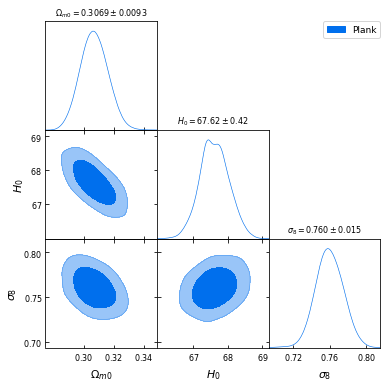

In [ ]:
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt   
# import matplotlib.pyplot as plt 

samples1 = MCSamplesFromCobaya(updated1_info, sampler1.products()["sample"])

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot([samples1], ["Om", "H0", "s80"], \
                     legend_labels=['Plank'], title_limit=1, filled=True)
plt.show()

Print likelihood-related statistic parameters, such as __mean__ for each parameters, __varians__ and __best-fit sample__...

In [ ]:
print(' marge stats ')
print(samples1.getMargeStats())
print()
print(' like stats ')
print(samples1.getLikeStats())

 marge stats 
Marginalized limits: 0.68; 0.95; 0.99

parameter           mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
Om                  3.0692576E-01  9.2616971E-03  2.9767746E-01  3.1611014E-01  two    2.8939426E-01  3.2501866E-01  two    2.8460233E-01  3.3189096E-01  two     \Omega_{m0}
H0                  6.7615132E+01  4.2290877E-01  6.7184384E+01  6.8020733E+01  two    6.6796189E+01  6.8459267E+01  two    6.6537863E+01  6.8693622E+01  two     H_0
M                  -1.9434238E+01  1.3070916E-02 -1.9446427E+01 -1.9421931E+01  two   -1.9458693E+01 -1.9408785E+01  two   -1.9467635E+01 -1.9401548E+01  two     M
s80                 7.5986197E-01  1.5148643E-02  7.4510816E-01  7.7520289E-01  two    7.3067697E-01  7.8995610E-01  two    7.2098065E-01  7.9844809E-01  two     \sigma_{8}
minuslogprior*     -3.7399980E-01  6.2743845E-01 -8.8526247E-01 -3.2641416E-01  two   -9.3107978E-01  9.9020

Then we use AIC and BIC respectively to determine the quality of this model.

In [ ]:
Llike_bfmodel1 = # input from samples
p = 4 # number of sampled parameters
n_data = 31 + 26 + 1701 + 63 # size of data

chi2_best_model1 = -2*Llike_bfmodel1
AIC_best_model1 = 2*p -2*Llike_bfmodel1
BIC_best_model1 = p*np.log(n_data) -2*Llike_bfmodel1

print('model 1: Planck 18')
print('best chi2 = ', chi2_best_model1)
print('best AIC = ', AIC_best_model1)
print('best BIC = ', BIC_best_model1)

The second one we use the SH0ES(R22) measurements as the priors.
We follow the similar steps to finish this process.

In [ ]:
info2 = {"likelihood": {"loglikeSNIa": loglikelihood},
         "params": {"Om": {"prior": {"min": 0.2, "max": 0.4}, \
                           "ref": {"min": 0.3, "max": 0.31}, \
                           "proposal": 0.005, "latex": r"\Omega_{m0}"}, \
                    "H0": {"prior": {"dist": "norm", "loc": 73.30, "scale": 1.04}, \
                           "ref": 73.30, "proposal": 0.002, "latex": r"H_0"}, \
                    "M": {"prior": {"min": -19.5, "max": -19.0}, \
                          "ref": {"min": -19.3, "max": -19.2}, \
                          "proposal": 0.005, "latex": r'M'}, \
                    "s80": {"prior":{"dist": "norm", "loc": 0.1, "scale": 1.2}, \
                            "ref": 0.7, "proposal": 0.002, "latex": r'\sigma_{8}'}}, \
         "sampler" : {"mcmc": {"Rminus1_stop": 0.01, "max_tries": 1000}}}  

info2["ouput"] = "chains/LCDMR22"
updated2_info, sampler2 = run(info2, force=True)  

INFO:loglikesnia:Initialized external likelihood.


[loglikesnia] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {loglikeSNIa: 6.15}


[model] Setting measured speeds (per sec): {loglikeSNIa: 6.15}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Initial point: Om:0.3098029, H0:73.3, M:-19.27309, s80:0.7


[mcmc] Initial point: Om:0.3098029, H0:73.3, M:-19.27309, s80:0.7


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2022-11-22 17:06:30 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2022-11-22 17:06:30 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2022-11-22 17:07:30 : 355 steps taken, and 134 accepted.


[mcmc] Progress @ 2022-11-22 17:07:30 : 355 steps taken, and 134 accepted.


INFO:mcmc:Learn + convergence test @ 160 samples accepted.


[mcmc] Learn + convergence test @ 160 samples accepted.


INFO:mcmc: - Acceptance rate: 0.359


[mcmc]  - Acceptance rate: 0.359


INFO:mcmc: - Convergence of means: R-1 = 13.528108 after 128 accepted steps


[mcmc]  - Convergence of means: R-1 = 13.528108 after 128 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:08:31 : 707 steps taken, and 276 accepted.


[mcmc] Progress @ 2022-11-22 17:08:31 : 707 steps taken, and 276 accepted.


INFO:mcmc:Learn + convergence test @ 320 samples accepted.


[mcmc] Learn + convergence test @ 320 samples accepted.


INFO:mcmc: - Acceptance rate: 0.393


[mcmc]  - Acceptance rate: 0.393


INFO:mcmc: - Convergence of means: R-1 = 1.510142 after 256 accepted steps


[mcmc]  - Convergence of means: R-1 = 1.510142 after 256 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:09:31 : 1050 steps taken, and 412 accepted.


[mcmc] Progress @ 2022-11-22 17:09:31 : 1050 steps taken, and 412 accepted.


INFO:mcmc:Learn + convergence test @ 480 samples accepted.


[mcmc] Learn + convergence test @ 480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.400


[mcmc]  - Acceptance rate: 0.400


INFO:mcmc: - Convergence of means: R-1 = 0.437916 after 384 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.437916 after 384 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:10:31 : 1402 steps taken, and 557 accepted.


[mcmc] Progress @ 2022-11-22 17:10:31 : 1402 steps taken, and 557 accepted.


INFO:mcmc:Learn + convergence test @ 640 samples accepted.


[mcmc] Learn + convergence test @ 640 samples accepted.


INFO:mcmc: - Acceptance rate: 0.407


[mcmc]  - Acceptance rate: 0.407


INFO:mcmc: - Convergence of means: R-1 = 6.669821 after 512 accepted steps


[mcmc]  - Convergence of means: R-1 = 6.669821 after 512 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:11:31 : 1751 steps taken, and 703 accepted.


[mcmc] Progress @ 2022-11-22 17:11:31 : 1751 steps taken, and 703 accepted.


INFO:mcmc:Learn + convergence test @ 800 samples accepted.


[mcmc] Learn + convergence test @ 800 samples accepted.


INFO:mcmc: - Acceptance rate: 0.396


[mcmc]  - Acceptance rate: 0.396


INFO:mcmc: - Convergence of means: R-1 = 9.210787 after 640 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.210787 after 640 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:12:31 : 2103 steps taken, and 820 accepted.


[mcmc] Progress @ 2022-11-22 17:12:31 : 2103 steps taken, and 820 accepted.


INFO:mcmc:Progress @ 2022-11-22 17:13:31 : 2445 steps taken, and 910 accepted.


[mcmc] Progress @ 2022-11-22 17:13:31 : 2445 steps taken, and 910 accepted.


INFO:mcmc:Learn + convergence test @ 960 samples accepted.


[mcmc] Learn + convergence test @ 960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.369


[mcmc]  - Acceptance rate: 0.369


INFO:mcmc: - Convergence of means: R-1 = 9.449878 after 768 accepted steps


[mcmc]  - Convergence of means: R-1 = 9.449878 after 768 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:14:31 : 2802 steps taken, and 1034 accepted.


[mcmc] Progress @ 2022-11-22 17:14:31 : 2802 steps taken, and 1034 accepted.


INFO:mcmc:Learn + convergence test @ 1120 samples accepted.


[mcmc] Learn + convergence test @ 1120 samples accepted.


INFO:mcmc: - Acceptance rate: 0.358


[mcmc]  - Acceptance rate: 0.358


INFO:mcmc: - Convergence of means: R-1 = 5.952304 after 896 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.952304 after 896 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:15:31 : 3158 steps taken, and 1143 accepted.


[mcmc] Progress @ 2022-11-22 17:15:31 : 3158 steps taken, and 1143 accepted.


INFO:mcmc:Progress @ 2022-11-22 17:16:31 : 3509 steps taken, and 1250 accepted.


[mcmc] Progress @ 2022-11-22 17:16:31 : 3509 steps taken, and 1250 accepted.


INFO:mcmc:Learn + convergence test @ 1280 samples accepted.


[mcmc] Learn + convergence test @ 1280 samples accepted.


INFO:mcmc: - Acceptance rate: 0.347


[mcmc]  - Acceptance rate: 0.347


INFO:mcmc: - Convergence of means: R-1 = 5.739488 after 1024 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.739488 after 1024 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:17:32 : 3865 steps taken, and 1355 accepted.


[mcmc] Progress @ 2022-11-22 17:17:32 : 3865 steps taken, and 1355 accepted.


INFO:mcmc:Learn + convergence test @ 1440 samples accepted.


[mcmc] Learn + convergence test @ 1440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.340


[mcmc]  - Acceptance rate: 0.340


INFO:mcmc: - Convergence of means: R-1 = 5.721788 after 1152 accepted steps


[mcmc]  - Convergence of means: R-1 = 5.721788 after 1152 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:18:32 : 4207 steps taken, and 1471 accepted.


[mcmc] Progress @ 2022-11-22 17:18:32 : 4207 steps taken, and 1471 accepted.


INFO:mcmc:Progress @ 2022-11-22 17:19:32 : 4560 steps taken, and 1573 accepted.


[mcmc] Progress @ 2022-11-22 17:19:32 : 4560 steps taken, and 1573 accepted.


INFO:mcmc:Learn + convergence test @ 1600 samples accepted.


[mcmc] Learn + convergence test @ 1600 samples accepted.


INFO:mcmc: - Acceptance rate: 0.333


[mcmc]  - Acceptance rate: 0.333


INFO:mcmc: - Convergence of means: R-1 = 3.605150 after 1280 accepted steps


[mcmc]  - Convergence of means: R-1 = 3.605150 after 1280 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:20:32 : 4916 steps taken, and 1679 accepted.


[mcmc] Progress @ 2022-11-22 17:20:32 : 4916 steps taken, and 1679 accepted.


INFO:mcmc:Learn + convergence test @ 1760 samples accepted.


[mcmc] Learn + convergence test @ 1760 samples accepted.


INFO:mcmc: - Acceptance rate: 0.327


[mcmc]  - Acceptance rate: 0.327


INFO:mcmc: - Convergence of means: R-1 = 2.128815 after 1408 accepted steps


[mcmc]  - Convergence of means: R-1 = 2.128815 after 1408 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:21:32 : 5271 steps taken, and 1777 accepted.


[mcmc] Progress @ 2022-11-22 17:21:32 : 5271 steps taken, and 1777 accepted.


INFO:mcmc:Progress @ 2022-11-22 17:22:32 : 5628 steps taken, and 1872 accepted.


[mcmc] Progress @ 2022-11-22 17:22:32 : 5628 steps taken, and 1872 accepted.


INFO:mcmc:Learn + convergence test @ 1920 samples accepted.


[mcmc] Learn + convergence test @ 1920 samples accepted.


INFO:mcmc: - Acceptance rate: 0.320


[mcmc]  - Acceptance rate: 0.320


INFO:mcmc: - Convergence of means: R-1 = 0.945490 after 1536 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.945490 after 1536 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:23:32 : 5971 steps taken, and 1964 accepted.


[mcmc] Progress @ 2022-11-22 17:23:32 : 5971 steps taken, and 1964 accepted.


INFO:mcmc:Progress @ 2022-11-22 17:24:32 : 6326 steps taken, and 2063 accepted.


[mcmc] Progress @ 2022-11-22 17:24:32 : 6326 steps taken, and 2063 accepted.


INFO:mcmc:Learn + convergence test @ 2080 samples accepted.


[mcmc] Learn + convergence test @ 2080 samples accepted.


INFO:mcmc: - Acceptance rate: 0.313


[mcmc]  - Acceptance rate: 0.313


INFO:mcmc: - Convergence of means: R-1 = 0.613884 after 1664 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.613884 after 1664 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:25:32 : 6693 steps taken, and 2180 accepted.


[mcmc] Progress @ 2022-11-22 17:25:32 : 6693 steps taken, and 2180 accepted.


INFO:mcmc:Learn + convergence test @ 2240 samples accepted.


[mcmc] Learn + convergence test @ 2240 samples accepted.


INFO:mcmc: - Acceptance rate: 0.308


[mcmc]  - Acceptance rate: 0.308


INFO:mcmc: - Convergence of means: R-1 = 0.310232 after 1792 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.310232 after 1792 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:26:32 : 7052 steps taken, and 2269 accepted.


[mcmc] Progress @ 2022-11-22 17:26:32 : 7052 steps taken, and 2269 accepted.


INFO:mcmc:Progress @ 2022-11-22 17:27:32 : 7396 steps taken, and 2379 accepted.


[mcmc] Progress @ 2022-11-22 17:27:32 : 7396 steps taken, and 2379 accepted.


INFO:mcmc:Learn + convergence test @ 2400 samples accepted.


[mcmc] Learn + convergence test @ 2400 samples accepted.


INFO:mcmc: - Acceptance rate: 0.306


[mcmc]  - Acceptance rate: 0.306


INFO:mcmc: - Convergence of means: R-1 = 0.139686 after 1920 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.139686 after 1920 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:28:32 : 7749 steps taken, and 2476 accepted.


[mcmc] Progress @ 2022-11-22 17:28:32 : 7749 steps taken, and 2476 accepted.


INFO:mcmc:Learn + convergence test @ 2560 samples accepted.


[mcmc] Learn + convergence test @ 2560 samples accepted.


INFO:mcmc: - Acceptance rate: 0.302


[mcmc]  - Acceptance rate: 0.302


INFO:mcmc: - Convergence of means: R-1 = 0.085116 after 2048 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.085116 after 2048 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:29:33 : 8103 steps taken, and 2573 accepted.


[mcmc] Progress @ 2022-11-22 17:29:33 : 8103 steps taken, and 2573 accepted.


INFO:mcmc:Progress @ 2022-11-22 17:30:33 : 8455 steps taken, and 2690 accepted.


[mcmc] Progress @ 2022-11-22 17:30:33 : 8455 steps taken, and 2690 accepted.


INFO:mcmc:Learn + convergence test @ 2720 samples accepted.


[mcmc] Learn + convergence test @ 2720 samples accepted.


INFO:mcmc: - Acceptance rate: 0.304


[mcmc]  - Acceptance rate: 0.304


INFO:mcmc: - Convergence of means: R-1 = 0.028427 after 2176 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028427 after 2176 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:31:33 : 8806 steps taken, and 2786 accepted.


[mcmc] Progress @ 2022-11-22 17:31:33 : 8806 steps taken, and 2786 accepted.


INFO:mcmc:Learn + convergence test @ 2880 samples accepted.


[mcmc] Learn + convergence test @ 2880 samples accepted.


INFO:mcmc: - Acceptance rate: 0.299


[mcmc]  - Acceptance rate: 0.299


INFO:mcmc: - Convergence of means: R-1 = 0.016079 after 2304 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.016079 after 2304 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:32:33 : 9159 steps taken, and 2884 accepted.


[mcmc] Progress @ 2022-11-22 17:32:33 : 9159 steps taken, and 2884 accepted.


INFO:mcmc:Progress @ 2022-11-22 17:33:33 : 9514 steps taken, and 2984 accepted.


[mcmc] Progress @ 2022-11-22 17:33:33 : 9514 steps taken, and 2984 accepted.


INFO:mcmc:Learn + convergence test @ 3040 samples accepted.


[mcmc] Learn + convergence test @ 3040 samples accepted.


INFO:mcmc: - Acceptance rate: 0.297


[mcmc]  - Acceptance rate: 0.297


INFO:mcmc: - Convergence of means: R-1 = 0.014883 after 2432 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.014883 after 2432 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:34:33 : 9868 steps taken, and 3090 accepted.


[mcmc] Progress @ 2022-11-22 17:34:33 : 9868 steps taken, and 3090 accepted.


INFO:mcmc:Learn + convergence test @ 3200 samples accepted.


[mcmc] Learn + convergence test @ 3200 samples accepted.


INFO:mcmc: - Acceptance rate: 0.298


[mcmc]  - Acceptance rate: 0.298


INFO:mcmc: - Convergence of means: R-1 = 0.028114 after 2560 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.028114 after 2560 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:35:33 : 10221 steps taken, and 3210 accepted.


[mcmc] Progress @ 2022-11-22 17:35:33 : 10221 steps taken, and 3210 accepted.


INFO:mcmc:Progress @ 2022-11-22 17:36:33 : 10563 steps taken, and 3310 accepted.


[mcmc] Progress @ 2022-11-22 17:36:33 : 10563 steps taken, and 3310 accepted.


INFO:mcmc:Learn + convergence test @ 3360 samples accepted.


[mcmc] Learn + convergence test @ 3360 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029704 after 2688 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029704 after 2688 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:37:33 : 10916 steps taken, and 3420 accepted.


[mcmc] Progress @ 2022-11-22 17:37:33 : 10916 steps taken, and 3420 accepted.


INFO:mcmc:Learn + convergence test @ 3520 samples accepted.


[mcmc] Learn + convergence test @ 3520 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.029030 after 2816 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.029030 after 2816 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:38:33 : 11268 steps taken, and 3523 accepted.


[mcmc] Progress @ 2022-11-22 17:38:33 : 11268 steps taken, and 3523 accepted.


INFO:mcmc:Progress @ 2022-11-22 17:39:33 : 11620 steps taken, and 3627 accepted.


[mcmc] Progress @ 2022-11-22 17:39:33 : 11620 steps taken, and 3627 accepted.


INFO:mcmc:Learn + convergence test @ 3680 samples accepted.


[mcmc] Learn + convergence test @ 3680 samples accepted.


INFO:mcmc: - Acceptance rate: 0.296


[mcmc]  - Acceptance rate: 0.296


INFO:mcmc: - Convergence of means: R-1 = 0.009689 after 2944 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.009689 after 2944 accepted steps


INFO:mcmc: - Updated covariance matrix of proposal pdf.


[mcmc]  - Updated covariance matrix of proposal pdf.


INFO:mcmc:Progress @ 2022-11-22 17:40:33 : 11969 steps taken, and 3721 accepted.


[mcmc] Progress @ 2022-11-22 17:40:33 : 11969 steps taken, and 3721 accepted.


INFO:mcmc:Progress @ 2022-11-22 17:41:33 : 12320 steps taken, and 3822 accepted.


[mcmc] Progress @ 2022-11-22 17:41:33 : 12320 steps taken, and 3822 accepted.


INFO:mcmc:Learn + convergence test @ 3840 samples accepted.


[mcmc] Learn + convergence test @ 3840 samples accepted.


INFO:mcmc: - Acceptance rate: 0.295


[mcmc]  - Acceptance rate: 0.295


INFO:mcmc: - Convergence of means: R-1 = 0.006122 after 3072 accepted steps


[mcmc]  - Convergence of means: R-1 = 0.006122 after 3072 accepted steps


INFO:mcmc: - Convergence of bounds: R-1 = 0.076180 after 3840 accepted steps


[mcmc]  - Convergence of bounds: R-1 = 0.076180 after 3840 accepted steps


INFO:mcmc:The run has converged!


[mcmc] The run has converged!


INFO:mcmc:Sampling complete after 3840 accepted steps.


[mcmc] Sampling complete after 3840 accepted steps.


After got the posteriors, we could load the samples and plot the triangle contour plot toward each parameters.

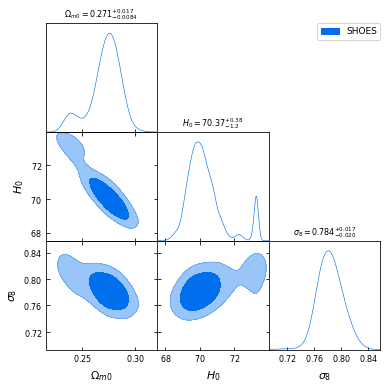

In [ ]:
samples2 = MCSamplesFromCobaya(updated2_info, sampler2.products()["sample"])

gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot([samples2], ["Om", "H0", "s80"], \
                     legend_labels=['SHOES'], title_limit=1, filled=True)
plt.show()

Print likelihood-related statistic parameters, such as __mean__ for each parameters, __varians__ and __best-fit sample__...

In [ ]:
print(' marge stats ')
print(samples2.getMargeStats())
print()
print(' like stats ')
print(samples2.getLikeStats())

 marge stats 
Marginalized limits: 0.68; 0.95; 0.99

parameter           mean           sddev          lower1         upper1         limit1 lower2         upper2         limit2 lower3         upper3         limit3 
Om                  2.7139898E-01  1.5122029E-02  2.6303915E-01  2.8813581E-01  two    2.3448347E-01  2.9465094E-01  two    2.3056270E-01  3.0237536E-01  two     \Omega_{m0}
H0                  7.0371806E+01  1.1836248E+00  6.9198028E+01  7.0751111E+01  two    6.8603627E+01  7.3480786E+01  two    6.8302283E+01  7.3541538E+01  two     H_0
M                  -1.9359691E+01  3.1942017E-02 -1.9392098E+01 -1.9348066E+01  two   -1.9402767E+01 -1.9279633E+01  two   -1.9414222E+01 -1.9267857E+01  two     M
s80                 7.8400934E-01  1.8934707E-02  7.6377439E-01  8.0096626E-01  two    7.5028507E-01  8.2273536E-01  two    7.3335621E-01  8.3422957E-01  two     \sigma_{8}
minuslogprior*      4.5307700E+00  2.5159199E+00  2.2290635E+00  7.2999986E+00  two   -6.6967732E-01  9.2572

Then we use AIC and BIC respectively to determine the quality of this model.

In [ ]:
Llike_bfmodel2 = # input from samples
p = 4 # number of sampled parameters
n_data = 31 + 26 + 1701 + 63 # size of data

chi2_best_model2 = -2*Llike_bfmodel2
AIC_best_model2 = 2*p -2*Llike_bfmodel2
BIC_best_model2 = p*np.log(n_data) -2*Llike_bfmodel2

print('model 2: SH0ES')
print('best chi2 = ', chi2_best_model2)
print('best AIC = ', AIC_best_model2)
print('best BIC = ', BIC_best_model2)

Finally, we plot the results used __P18__ and __R22__ as the priors together, then we can have a triangle contour plot respected to $H_0$, $\Omega_{m0}$ and $\sigma_8$.

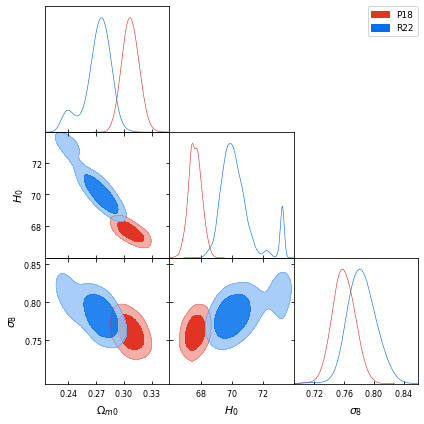

In [ ]:
gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot([samples1, samples2], ["Om", "H0", "s80"], \
                     legend_labels=['P18','R22'], ls=['--', ':'], filled=True)
plt.show()

End of notebook